In [ ]:
# !pip install tensorflow-text
# !pip install tf-models-official

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

**Importing Dataset and Feature Class and Target Class**

In [3]:
#df = pd.read_csv("/content/drive/MyDrive/deceptiveopinion/preprocess.csv", index_col=0)
df = pd.read_csv("preprocess.csv", index_col=0)
X = df['Ori_Review']
y = df['label']

In [4]:
df.head()

,rating,label,Ori_Review
category,,,
Home_and_Kitchen_5,5,1,"Love this! Well made, sturdy, and very comfor..."
Home_and_Kitchen_5,5,1,"love it, a great upgrade from the original. I..."
Home_and_Kitchen_5,5,1,This pillow saved my back. I love the look and...
Home_and_Kitchen_5,1,1,"Missing information on how to use it, but it i..."
Home_and_Kitchen_5,5,1,Very nice set. Good quality. We have had the s...


**Splitting the Data for Training and Testing**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Loading BERT pre-processing model from tensorflow hub** 

In [6]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [7]:
text_inputs = [keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

seq_length = 512  # Set sequence length
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))

preprocessed_text = bert_pack_inputs(tokenized_inputs)

In [8]:
preprocessed_text

{'input_type_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_word_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_mask': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>}

{'whiskers': [<matplotlib.lines.Line2D at 0x2315eee8dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x2315eee9300>,
 'boxes': [<matplotlib.lines.Line2D at 0x2315eee8b50>],
 'medians': [<matplotlib.lines.Line2D at 0x2315eee9840>],
 'fliers': [<matplotlib.lines.Line2D at 0x2315eee9ae0>],
 'means': []}

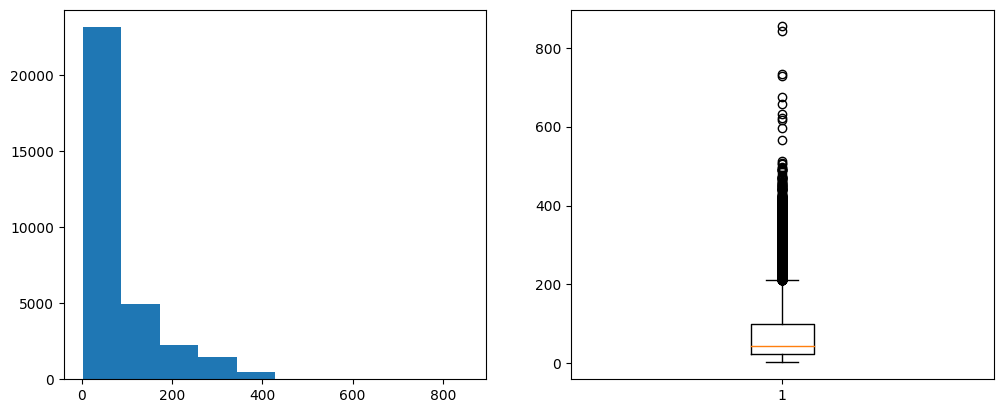

In [9]:
sizes = []
tokens = tokenize(X_train)
for i in range(tokens.shape[0]):
  sizes.append(tokens[i].shape[0])

from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.hist(sizes)
ax2.boxplot(sizes)

**Loading the BERT pre-trained model which provides dense vector representations for natural language by using a deep, pre-trained neural network.**

In [ ]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [ ]:
# Train all BERT layers as suggested by BERT developers
bert_encoder.trainable = True

# Bert layers
outputs = bert_encoder(preprocessed_text)

# Dense layers
l = keras.layers.Dense(1, activation='sigmoid', name="output") (outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = keras.Model(inputs=text_inputs, outputs = [l])

In [ ]:
model.input_shape

In [ ]:
epochs = 2
batch_size = 8
init_lr = 3e-5  # best of [5e-5, 3e-5, 2e-5]

train_data_size = X_train.shape[0]
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

test_data_size = X_test.shape[0]

In [ ]:
optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='accuracy')

model.summary()

**Training the Model**

In [ ]:
bert_encoder.trainable = False
model.fit(X_train,
          y_train,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=(X_test, y_test))

In [ ]:
prediction = model.predict(X_test)
prediction_real = model.predict(X_test[y_test == 0])
prediction_fake = model.predict(X_test[y_test == 1])

In [ ]:
prediction_bi_real = prediction_real.copy()
prediction_bi_real[np.where(prediction_real <= 0.5)] = 0
prediction_bi_real[np.where(prediction_real > 0.5)] = 1
print('True Positive Rate:', '{:.2%}'.format(1 - sum(prediction_bi_real)[0] / len(prediction_bi_real)))

prediction_bi_fake = prediction_fake.copy()
prediction_bi_fake[np.where(prediction_fake <= 0.5)] = 0
prediction_bi_fake[np.where(prediction_fake > 0.5)] = 1
print('True Negative Rate:', '{:.2%}'.format(sum(prediction_bi_fake)[0] / len(prediction_bi_fake)))

In [ ]:
demo_ind = np.random.choice(len(X_test.index))
realfake = 'Real' if y_test[demo_ind] == 0 else 'Fake'
prediction = model.predict([X_test[demo_ind]])
prediction_rf = 'Real' if prediction <= 0.5 else 'Fake'

print(f'{realfake} review to be fed to model:\n', X_test[demo_ind], '\n')
print(f'Model prediction: {prediction_rf}')